# Single Shot Multibox Detection

I was having difficulties with RandomIoUCrop, It wasn't working great for various reasons, the resulting images had bad GT boxes, or just timed out due to not being able to get a high enough IoU with a GT box. There are multiple fixes like adding in a sampler_option = 0.0, so it's never impossible, but I still found the resulting GT boxes were not great, you would get images clearly containing people, without any GT box. So I got Chat GPT to create a class that centers crops around a GT box. 

In [28]:
import os, torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.ops import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torch import nn, optim

def _area_xyxy(b): 
    return (b[:,2]-b[:,0]).clamp(0) * (b[:,3]-b[:,1]).clamp(0)

def _clip_to_canvas(boxes, H, W):
    x1 = boxes[:,0].clamp(0, W-1)
    y1 = boxes[:,1].clamp(0, H-1)
    x2 = boxes[:,2].clamp(0, W-1)
    y2 = boxes[:,3].clamp(0, H-1)
    # ensure x2>=x1, y2>=y1 after clamp
    x2 = torch.maximum(x2, x1)
    y2 = torch.maximum(y2, y1)
    return torch.stack([x1,y1,x2,y2], dim=1)

class SafeBoxCenteredCrop(nn.Module):
    """
    Object-centric crop around a randomly chosen GT box,
    with visibility/AR/scale checks and bounded retries.
    """
    def __init__(
        self,
        out_size=(300,300),
        context=(1.2, 2.0),           # crop size = context * target box size
        scale_img=(0.3, 1.0),         # crop area as fraction of image area (feasibility guard)
        ratio=(0.6, 1.8),             # crop aspect ratio bounds (w/h)
        max_trials=30,
        target_vis_thresh=0.7,        # target box must be at least 70% visible
        keep_vis_thresh=0.5,          # other boxes kept if ≥50% visible
        antialias=True
    ):
        super().__init__()
        self.out_size = out_size
        self.context = context
        self.scale_img = scale_img
        self.ratio = ratio
        self.max_trials = max_trials
        self.target_vis_thresh = target_vis_thresh
        self.keep_vis_thresh = keep_vis_thresh
        self.antialias = antialias

    def forward(self, sample):
        img: tv_tensors.Image = sample["image"]
        boxes: tv_tensors.BoundingBoxes = sample["boxes"]
        labels: torch.Tensor = sample["labels"]

        C, H, W = img.shape
        if boxes.numel() == 0:
            # no boxes → fallback to simple resize
            return T.Resize(self.out_size, antialias=self.antialias)(sample)

        img_area = float(H * W)
        b = boxes.as_subclass(torch.Tensor)  # (N,4) float xyxy
        areas = _area_xyxy(b)
        # pick a target box proportional to sqrt(area) to bias toward larger persons
        weights = (areas.clamp(min=1)).sqrt()
        tidx = torch.multinomial(weights, 1).item()

        for _ in range(self.max_trials):
            tb = b[tidx]  # target box
            bw = (tb[2]-tb[0]).item()
            bh = (tb[3]-tb[1]).item()
            if bw < 1 or bh < 1:
                continue

            # sample context scale
            s = torch.empty(1).uniform_(*self.context).item()
            crop_w = max(1.0, s * bw)
            crop_h = max(1.0, s * bh)

            # optional AR jitter within bounds
            ar_min, ar_max = self.ratio
            # adjust width/height to satisfy aspect ratio softly
            ar = crop_w / crop_h
            if ar < ar_min:
                crop_w = ar_min * crop_h
            elif ar > ar_max:
                crop_h = crop_w / ar_max

            # make sure crop area is not absurd vs image
            crop_area = crop_w * crop_h
            if not (self.scale_img[0]*img_area <= crop_area <= self.scale_img[1]*img_area):
                # rescale to nearest bound
                target_area = min(max(crop_area, self.scale_img[0]*img_area), self.scale_img[1]*img_area)
                scale = (target_area / (crop_w*crop_h))**0.5
                crop_w *= scale
                crop_h *= scale

            # choose crop center near target box center with some jitter
            cx = (tb[0] + tb[2]) / 2
            cy = (tb[1] + tb[3]) / 2
            jx = (torch.randn(1).item() * 0.15) * bw  # 15% bw jitter
            jy = (torch.randn(1).item() * 0.15) * bh  # 15% bh jitter
            cx = (cx + jx).clamp(0, W-1)
            cy = (cy + jy).clamp(0, H-1)

            x1 = (cx - crop_w/2); y1 = (cy - crop_h/2)
            x2 = (cx + crop_w/2); y2 = (cy + crop_h/2)

            crop = torch.tensor([[x1,y1,x2,y2]], dtype=b.dtype, device=b.device)
            crop = _clip_to_canvas(crop, H, W)[0]

            # compute visibility of each box inside crop
            inter = torch.stack([
                torch.maximum(b[:,0], crop[0]),
                torch.maximum(b[:,1], crop[1]),
                torch.minimum(b[:,2], crop[2]),
                torch.minimum(b[:,3], crop[3]),
            ], dim=1)
            inter = _clip_to_canvas(inter, H, W)
            inter_area = _area_xyxy(inter)
            box_area = _area_xyxy(b).clamp(min=1)
            vis_frac = (inter_area / box_area)  # per-box visible fraction

            # require target box visibility
            if vis_frac[tidx].item() < self.target_vis_thresh:
                continue

            # keep boxes with enough visibility
            keep = vis_frac >= self.keep_vis_thresh
            if keep.sum() == 0:
                continue

            # translate+clip kept boxes to crop frame
            kb = b[keep].clone()
            kb[:,0::2] = kb[:,0::2].clamp(crop[0], crop[2]) - crop[0]
            kb[:,1::2] = kb[:,1::2].clamp(crop[1], crop[3]) - crop[1]

            # apply crop to image
            x1i, y1i, x2i, y2i = crop.tolist()
            x1i, y1i, x2i, y2i = int(x1i), int(y1i), int(x2i), int(y2i)
            img_c = img[:, y1i:y2i, x1i:x2i]

            # resize to output
            resize = T.Resize(self.out_size, antialias=self.antialias)
            img_c = resize(tv_tensors.Image(img_c))
            # resize boxes accordingly
            inH, inW = y2i - y1i, x2i - x1i
            scale_x = self.out_size[1] / max(1, inW)
            scale_y = self.out_size[0] / max(1, inH)
            kb[:, [0,2]] *= scale_x
            kb[:, [1,3]] *= scale_y

            out = {
                "image": img_c,
                "boxes": tv_tensors.BoundingBoxes(
                    kb, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=self.out_size
                ),
                "labels": labels[keep],
            }
            return out

        # Fallback if no candidate passed quality in max_trials
        fallback = T.Compose([
            T.RandomResizedCrop(size=self.out_size, scale=(0.8,1.0), ratio=(0.75,1.5), antialias=True)
        ])
        out = fallback({"image": img, "boxes": boxes, "labels": labels})
        return out

In [29]:
class PennFudan(Dataset):
    def __init__(self, root, train=True):
        self.root = root
        self.imgs  = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))
        # SSD pipeline: photometric --> geometric --> bbox cleanup --> float
        if train:
            self.tf = T.Compose([
                T.ToImage(),
                T.RandomPhotometricDistort(),
                T.RandomChoice([
                    SafeBoxCenteredCrop(out_size=(300,300),
                                        context=(1.3, 2.2),
                                        scale_img=(0.25, 0.95),
                                        ratio=(0.6, 1.8),
                                        max_trials=30,
                                        target_vis_thresh=0.7,
                                        keep_vis_thresh=0.5),
                    T.RandomResizedCrop(size=(300,300), scale=(0.85,1.0), ratio=(0.75,1.5), antialias=True),
                    T.Identity(),
                ], p=[0.5, 0.3, 0.2]),
                T.RandomHorizontalFlip(p=0.5),
                T.SanitizeBoundingBoxes(min_size=2),
                T.ToDtype(torch.float32, scale=True),
            ])
        else:
            self.tf = T.Compose([
                T.ToImage(),
                T.Resize((300, 300), antialias=True),
                T.SanitizeBoundingBoxes(min_size=1),
                T.ToDtype(torch.float32, scale=True),
            ])

    def __len__(self): 
        return len(self.imgs)

    def __getitem__(self, idx):
        ip = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mp = os.path.join(self.root, "PedMasks",  self.masks[idx])

        img  = read_image(ip)                  # (3,H,W), uint8
        mask = read_image(mp)[0]               # (H,W), instance ids
        ids  = torch.unique(mask)[1:]          # drop background=0
        masks = (mask[None] == ids[:, None, None]).to(torch.uint8)  # (N,H,W)
        boxes = masks_to_boxes(masks)          # (N,4) xyxy on original size

        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)   # 1 = person

        img = tv_tensors.Image(img)
        boxes = tv_tensors.BoundingBoxes(
            boxes, format=tv_tensors.BoundingBoxFormat.XYXY,
            canvas_size=img.shape[-2:]
        )

        sample = {"image": img, "boxes": boxes, "labels": labels}
        sample = self.tf(sample)

        out = {
            "boxes":  torch.as_tensor(sample["boxes"], dtype=torch.float32),
            "labels": sample["labels"]
        }
        return sample["image"], out

def collate(batch):
    imgs, targets = list(zip(*batch))
    return torch.stack(imgs, 0), list(targets)

root = "PennFudanPed"
train_ds = PennFudan(root, train=True)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,
                          num_workers=0, collate_fn=collate)


In [36]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as TF

for i in range(0, 6):
    print(i)
    img, label = train_ds[i]

    img_uint8 = (img * 255).to(torch.uint8)  

    out = draw_bounding_boxes(img_uint8, label["boxes"], colors="red", width=2)
    pil_out = TF.to_pil_image(out)
    pil_out.show()

0
1
2
3
4
5


![Img1](figures/img1.png)
![Img2](figures/img2.png)
![Img3](figures/img3.png)
![Img4](figures/img4.png)
![Img5](figures/img5.png)

In [31]:
from torchvision.models import resnet34, ResNet34_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet34(weights="IMAGENET1K_V1").to(device).eval()

In [32]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Original Architecture

| Stage    | Operation                        | Output Shape (C × H × W) |
| -------- | -------------------------------- | ------------------------ |
| Input    | —                                | 3 × 300 × 300            |
| Conv1    | 7×7, stride 2, pad 3             | 64 × 150 × 150           |
| MaxPool  | 3×3, stride 2, pad 1             | 64 × 75 × 75             |
| Layer 1  | 3 blocks, stride 1               | 64 × 75 × 75             |
| Layer 2  | 4 blocks, stride 2 (first block) | 128 × 38 × 38            |
| Layer 3  | 6 blocks, stride 2 (first block) | 256 × 19 × 19            |
| Layer 4  | 3 blocks, stride 2 (first block) | 512 × 10 × 10            |
| AvgPool  | global (kernel = 10×10)          | 512 × 1 × 1              |
| FC       | 1000 (ImageNet)                  | —                        |

### Adjusted Architecture

| Stage    | Operation                        | Output Shape (C × H × W) | Anchors |
| -------- | -------------------------------- | ------------------------ |---------|
| Input    | —                                | 3 × 300 × 300            | No      |
| Conv1    | 7×7, stride 2, pad 3             | 64 × 150 × 150           | No      |
| MaxPool  | 3×3, stride 2, pad 1             | 64 × 75 × 75             | No      |
| Layer 1  | 3 blocks, stride 1               | 64 × 75 × 75             | No      |
| Layer 2  | 4 blocks, stride 2 (first block) | 128 × 38 × 38            | Yes     |
| Layer 3  | 6 blocks, stride 2 (first block) | 256 × 19 × 19            | Yes     |
| Layer 4  | 3 blocks, stride 2 (first block) | 512 × 10 × 10            | Yes     |
| C5       | Conv2d(512, 256, ks=3, s=2, p=1) | 256 × 5 × 5              | Yes     |
| C6       | Conv2d(256, 256, ks=3, s=2, p=1) | 256 × 3 × 3              | Yes     |
| C7       | Conv2d(256, 256, ks=3, s=2, p=1) | 256 × 1 × 1              | Yes     |



| Map         | in\_ch | mid\_ch  | out\_ch | Why       |
| ------------| -----| ----| ----| -------------------- |
| C5 (10-->5) | 512  | 256 | 256 |-                     |
| C6 (5-->3)  | 256  | 128 | 256 |-                     |
| C7 (3-->1)  | 256  | -   | 256 | Single 3×3, s=1, p=0 |


In [33]:
from torch import nn, optim

def ds_block(in_ch, mid_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, mid_ch, 1, 1, 0, bias=False),
        nn.BatchNorm2d(mid_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_ch, out_ch, 3, 2, 1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

In [34]:
class ResNet34Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        bone = resnet34(weights="IMAGENET1K_V1")

        self.stem = nn.Sequential(bone.conv1, 
                                  bone.bn1,
                                  bone.relu, 
                                  bone.maxpool
                                  )
        
        self.layer1 = bone.layer1
        self.layer2 = bone.layer2
        self.layer3 = bone.layer3
        self.layer4 = bone.layer4

        self.c5 = ds_block(512, 256, 256)
        self.c6 = ds_block(256, 128, 256)
        self.c7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.out_l2 = nn.LazyConv2d(256, 1, bias=False)
        self.out_l3 = nn.LazyConv2d(256, 1, bias=False)
        self.out_l4 = nn.LazyConv2d(256, 1, bias=False)

    def forward(self, x):
        x = self.stem(x)          # 64 x 75 x 75
        o2 = self.layer1(x)       # 64 x 75 x 75
        o3 = self.layer2(o2)      # 128 x 38 x 38
        o4 = self.layer3(o3)      # 256 x 19 x 19
        o5 = self.layer4(o4)      # 512 x 10 x 10

        f3 = self.out_l2(o3)      # 256 x 38 x 38
        f4 = self.out_l3(o4)      # 256 x 19 x 19
        f5 = self.out_l4(o5)      # 256 x 10 x 10

        f6 = self.c5(o5)          # 256 x 5 x 5
        f7 = self.c6(f6)          # 256 x 3 x 3
        f8 = self.c7(f7)          # 256 x 1 x 1

        return [f3, f4, f5, f6, f7, f8]


c:\Users\rowek\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


f3: (1, 256, 38, 38)
f4: (1, 256, 19, 19)
f5: (1, 256, 10, 10)
f6: (1, 256, 5, 5)
f7: (1, 256, 3, 3)
f8: (1, 256, 1, 1)


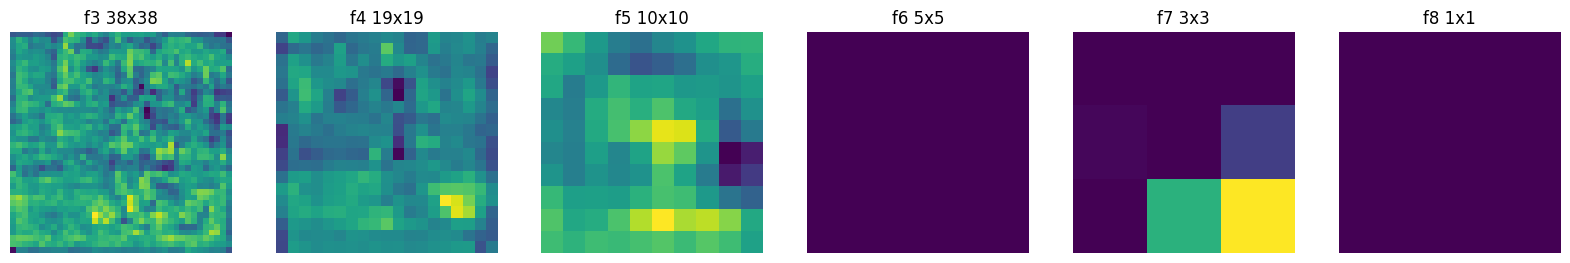

In [35]:
import matplotlib.pyplot as plt

img, label = train_ds[0]
model = ResNet34Backbone().eval()
with torch.no_grad():
    maps = model(img.unsqueeze(0))

for i, f in enumerate(maps, 3):
    print(f"f{i}: {tuple(f.shape)}")

fig, axs = plt.subplots(1, len(maps), figsize=(20, 4))
for i, f in enumerate(maps):
    fmap = f[0, 0].detach().cpu()
    axs[i].imshow(fmap, cmap="viridis")
    axs[i].set_title(f"f{i+3} {f.shape[2]}x{f.shape[3]}")
    axs[i].axis("off")
#plt.show()

![Feature Maps](figures/fmaps.png)